In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import gym
import numpy as np
import random
from keras.layers import Dense, Activation, Lambda, Input, concatenate, Add
from keras.models import Sequential,Model
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import files
from collections import deque
import os
from gym.wrappers import Monitor
from gym import logger as gymlogger
import glob
import io
import base64

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class Deepqnet:
    def __init__(self, sta_size, act_size):
        self.df=0.99    
        self.eps_decay=0.98
        self.eps_min=0.01
        self.act_size=act_size
        self.val=0
        self.sta_size=sta_size
        self.mem=deque(maxlen=2000)
        self.model_t=self.neural_net()
        self.model=self.neural_net()
        self.eps=1.0 
        self.update_fn()
    
    #def loadm(self)
    #Epsilon greedy actions
    def act(self, state):
        if(np.random.uniform(0, 1)<=self.eps):
            return random.randrange(self.act_size)
        else:
          act_values=self.model.predict(state)
          return np.argmax(act_values[0]) 
    
    #Update Weights
    def update_fn(self):
        self.model_t.set_weights(self.model.get_weights())

    def neural_net(self):
        inp = Input(shape=(self.sta_size,))
        x = Dense(32, input_shape=(self.sta_size,), activation='relu', kernel_initializer='he_uniform')(inp)
        x = Dense(16, activation='relu', kernel_initializer='he_uniform')(x)
        aa = Dense(self.act_size, kernel_initializer='he_uniform')(x)
        aa = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True),output_shape=(self.act_size,))(aa)
        sv = Dense(1, kernel_initializer='he_uniform')(x)
        sv = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(self.act_size,))(sv)
        q_value = Add()([sv, aa])
        model = Model(input=inp, output=q_value)
        model.compile(loss='mse', optimizer=Adam(lr=0.001))
        return(model)

    #save model
    def model_s(self, name):
        self.model.save(name)
    
    #Memory
    def rem(self, state, act, rew, nxt_sta, done):
        self.mem.append((state, act, rew, nxt_sta, done))

    #Update Rewards
    def execute(self, b_size):
        m_bat=random.sample(self.mem, b_size)
        for sta, act, rew, nxt_sta, done in m_bat:
            tgt=self.model.predict(sta)
            if(not done):
                fut_q =self.model_t.predict(nxt_sta)[0]
                tgt[0][act]=rew+(self.df*np.amax(fut_q))
            else:
                tgt[0][act]=rew
            h=self.model.fit(sta, tgt, epochs=1, verbose=0)
        loss=h.history['loss'][0]
        return loss

2
4



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            17          dense_2[0][0]                    
_____________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ad...)`





Episode: 0/501, Reward: 18.0, Loss: 0, Epsilon: 1.0
saving the model
Episode: 1/501, Reward: 10.0, Loss: 0, Epsilon: 0.98


Episode: 2/501, Reward: 13.0, Loss: 0.5881485342979431, Epsilon: 0.96
Episode: 3/501, Reward: 27.0, Loss: 0.08464404195547104, Epsilon: 0.94
Episode: 4/501, Reward: 9.0, Loss: 0.004601154942065477, Epsilon: 0.92
Episode: 5/501, Reward: 13.0, Loss: 0.1119028702378273, Epsilon: 0.9
Episode: 6/501, Reward: 19.0, Loss: 0.05051904544234276, Epsilon: 0.89
Episode: 7/501, Reward: 30.0, Loss: 3.0526840686798096, Epsilon: 0.87
Episode: 8/501, Reward: 27.0, Loss: 0.21403972804546356, Epsilon: 0.85
Episode: 9/501, Reward: 50.0, Loss: 0.053149882704019547, Epsilon: 0.83
Episode: 10/501, Reward: 39.0, Loss: 0.016467049717903137, Epsilon: 0.82
Episode: 11/501, Reward: 41.0, Loss: 0.001312376232817769, Epsilon: 0.8
Episode: 12/501, Reward: 16.0, Loss: 0.12415837496519089, Epsilon: 0.78
Episode: 13/501, Reward: 21.0, Loss: 0.3333592414855957, Epsilon: 0.77
Episode: 14/501, Rew

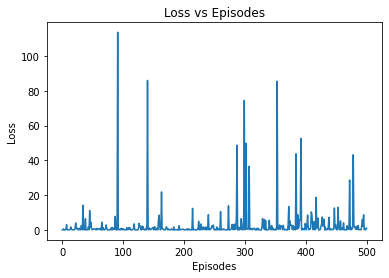

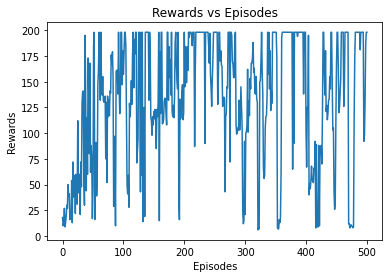

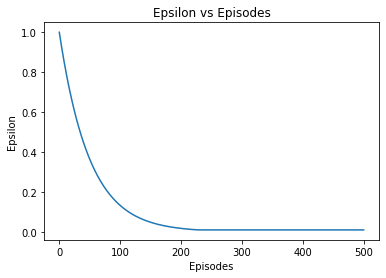

In [0]:
if __name__ == "__main__":
    batch_size = 32
    env = gym.make('CartPole-v0')
    action_size = env.action_space.n
    print(action_size)
    state_size = env.observation_space.shape[0]
    print(state_size)
    agent = Deepqnet(state_size, action_size)
    loss_val=[]
    scores = []
    eps_val=[]
    epis=501
    done = False
    loss=0

    for i in range(epis):
        done=False
        state = env.reset()
        state = np.reshape(state,[1, state_size])
        total_reward = 0
        while not done:
            action = agent.act(state)
            sta_nxt, reward, done, info = env.step(action)
            sta_nxt = np.reshape(sta_nxt, [1, state_size])
            reward = reward if not done else -1
            agent.rem(state, action, reward, sta_nxt, done)
            total_reward += reward
            state = sta_nxt
            if done:
                scores.append(total_reward)
                agent.update_fn()
                eps_val.append(agent.eps)
                loss_val.append(loss)        
                print("Episode: {}/{}, Reward: {}, Loss: {}, Epsilon: {:.2}".format(i, epis, total_reward, loss, agent.eps))
                if(agent.eps>agent.eps_min):
                    agent.eps*=agent.eps_decay

                break
            
            if len(agent.mem) > batch_size:
                loss=agent.execute(batch_size)

        if i % 100 == 0:
            print('saving the model')
            model_name = "cartpole_duel_dqn_final_20.h5"
            plot_name = "score_plot"
            model_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/", model_name)
            plot_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/", plot_name)
            agent.model_s(model_path)
            # saving the figure
            #print(scores)
            #plt.savefig('score_plot.jpg')
            #files.download('score_plot.jpg')
            #print(loss_val)
            #plt.savefig('loss.jpg')
            #files.download('loss.jpg')

    plt.figure(1)             
    plt.plot(loss_val)
    plt.title('Loss vs Episodes')
    plt.ylabel('Loss')
    plt.xlabel('Episodes')
    
    plt.figure(2)             
    plt.plot(scores)
    plt.title('Rewards vs Episodes')
    plt.ylabel('Rewards')
    plt.xlabel('Episodes')
    
    plt.figure(3)             
    plt.plot(eps_val)
    plt.title('Epsilon vs Episodes')
    plt.ylabel('Epsilon')
    plt.xlabel('Episodes')